In [ ]:
## AGENDA
## - Link prediction

In [ ]:
## SET LIBRARY

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx

/Users/boO/.pyenv/versions/3.6.6/lib/python3.6/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.figsize': (15, 15),
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False})

In [ ]:
## SET WORK PATH

In [3]:
#work_path = '/home/dmig/work/this-book/neo4j-book'
work_path = '/Users/boO/data8/data.student/neo4j-book/neo4j-book'
os.chdir(work_path)

In [ ]:
#from py2neo import Graph
#graph = Graph("bolt://neo4j.sktai.io:30074", auth=("neo4j","!neo4j00"))

In [ ]:
# https://github.com/neo4j-contrib/neo4j-apoc-procedures/releases/tag/3.5.0.1
#mv ./apoc-3.5.0.1-all.jar $Neo4J_HOME/plugins

In [ ]:
## SET GRAPH

In [4]:
from neo4j import GraphDatabase
class Neo4jConnection:
    
    def __init__(self, uri, user, pwd):
        self.__uri = uri
        self.__user = user
        self.__pwd = pwd
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response

In [5]:
#gph_conn = Neo4jConnection(uri="bolt://neo4j.sktai.io:30074", user="neo4j", pwd="!neo4j00")
#gph_conn = Neo4jConnection(uri="bolt://localhost:7687", user="neo4j", pwd="!neo4j00")
gph_conn = Neo4jConnection(uri="bolt://127.0.0.1:7687", user="neo4j", pwd="!neo4j00")

In [6]:
gph_conn.query("""
               CALL db.schema()
               """)

[<Record nodes=[<Node id=-1 labels=frozenset({'User'}) properties={'indexes': [], 'name': 'User', 'constraints': []}>] relationships=[<Relationship id=-1 nodes=(<Node id=-1 labels=frozenset({'User'}) properties={'indexes': [], 'name': 'User', 'constraints': []}>, <Node id=-1 labels=frozenset({'User'}) properties={'indexes': [], 'name': 'User', 'constraints': []}>) type='IS_LINKED_TO' properties={}>]>]

In [7]:
pd.DataFrame(gph_conn.query("""
               CALL apoc.meta.stats()
               """)).T.values

array([[1],
       [1],
       [1],
       [500],
       [15356],
       [{'User': 500}],
       [{'(:User)-[:IS_LINKED_TO]->()': 15356, '()-[:IS_LINKED_TO]->()': 15356, '()-[:IS_LINKED_TO]->(:User)': 15356}],
       [{'IS_LINKED_TO': 15356}],
       [{'relTypeCount': 1, 'propertyKeyCount': 1, 'labelCount': 1, 'nodeCount': 500, 'relCount': 15356, 'labels': {'User': 500}, 'relTypes': {'(:User)-[:IS_LINKED_TO]->()': 15356, '()-[:IS_LINKED_TO]->()': 15356, '()-[:IS_LINKED_TO]->(:User)': 15356}}]],
      dtype=object)

In [ ]:
gph_conn.query("""
          MATCH (n)
          DETACH DELETE n
          """)

In [ ]:
## LOAD DATA

In [8]:
gph = nx.read_edgelist("{}/data/graph_T1.edgelist.txt".format(work_path))

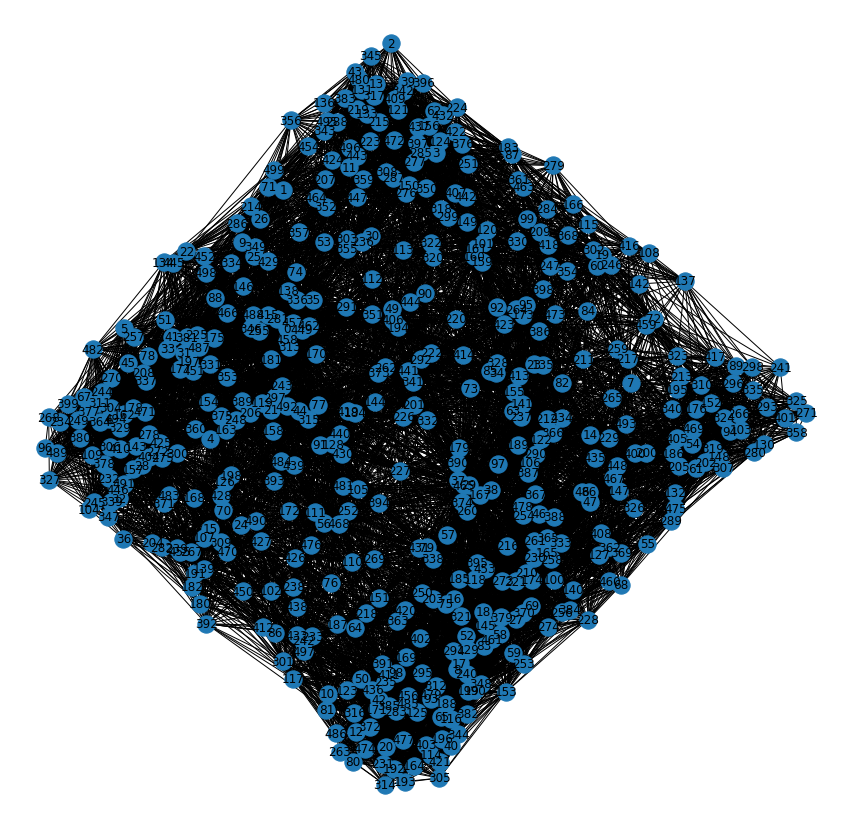

In [9]:
pos = nx.spring_layout(gph, k=0.3)
nx.draw_networkx(gph, pos)
plt.savefig('{}/output/T1.png'.format(work_path), dpi=600, bbox_inches='tight')

In [10]:
tbl = pd.read_csv("{}/data/graph_T1.edgelist.txt".format(work_path), sep=" ", header=None)
tbl.columns = ["mbr", "nbr"]

In [11]:
tbl1 = pd.read_csv("{}/data/graph_T2.edgelist.txt".format(work_path), sep=" ", header=None)
tbl1.columns = ["mbr", "nbr"]

In [ ]:
tbl.head()

In [12]:
print("T1: {}".format(tbl.shape))
print("T2: {}".format(tbl1.shape))

T1: (15356, 2)
T2: (19195, 2)


In [ ]:
## Nodes added

In [13]:
pd.concat([tbl1, tbl, tbl]).drop_duplicates(keep=False)

,mbr,nbr
2,0,49
3,0,320
14,0,498
18,0,53
23,0,444
...,...,...
19173,484,492
19177,486,497
19185,489,491
19190,491,494


In [ ]:
## Nodes removed

In [14]:
pd.concat([tbl, tbl1, tbl1]).drop_duplicates(keep=False)

,mbr,nbr


In [ ]:
## Save node and edge

In [ ]:
node_id = np.union1d(tbl.mbr.unique(), tbl.nbr.unique())
print("number of nodes: {}".format(len(node_id)))
#node_id = np.random.choice(node_id, size=100000, replace=False)
node_id = pd.DataFrame(node_id, columns=['id:ID'])
node_id[':LABEL'] = 'User'
node_id.to_csv("{}/data/node_t1.csv".format(work_path), index=False)

In [ ]:
tbl.columns = [':START_ID',':END_ID']
tbl[':TYPE'] = 'IS_LINKED_TO'
tbl.to_csv("{}/data/edge_t1.csv".format(work_path), index=False)

In [ ]:
## LOAD GRAPH

In [ ]:
!bin/neo4j-admin import --nodes=import/node_t1.csv --relationships=import/edge_t1.csv

In [ ]:
## same community

In [17]:
gph_conn.query("""
               MATCH (m:User {id: "3" })
               MATCH (n:User {id: "11" }) 
               RETURN gds.alpha.linkprediction.sameCommunity(m, n, "louvain") as sameCommunity
               """)

[<Record sameCommunity=0.0>]

In [ ]:
## distance-based

In [19]:
gph_conn.query("""
               CALL gds.graph.drop("graph")
               """)
gph_conn.query("""
               CALL gds.graph.create("graph", "User", {IS_LINKED_TO: {type: 'IS_LINKED_TO', orientation: 'UNDIRECTED', aggregation: 'SINGLE'}})
               """)

Query failed: {code: Neo.ClientError.Procedure.ProcedureCallFailed} {message: Failed to invoke procedure `gds.graph.drop`: Caused by: java.lang.IllegalArgumentException: Graph with name `graph` does not exist and can't be removed.}


[<Record graphName='graph' nodeProjection={'User': {'properties': {}, 'label': 'User'}} relationshipProjection={'IS_LINKED_TO': {'orientation': 'UNDIRECTED', 'aggregation': 'SINGLE', 'type': 'IS_LINKED_TO', 'properties': {}}} nodeCount=500 relationshipCount=30712 createMillis=76>]

In [20]:
gph_conn.query("""
               CALL gds.alpha.allShortestPaths.stream("graph", {})
               YIELD sourceNodeId, targetNodeId, distance
               WITH gds.util.asNode(sourceNodeId) AS mbr, gds.util.asNode(targetNodeId) AS nbr, 1.0 / distance as score
               WHERE NOT ((mbr)-[:IS_LINKED_TO]-(nbr))
               RETURN mbr.id, nbr.id, score
               LIMIT 10
               """)

[<Record mbr.id='67' nbr.id='0' score=0.5>,
 <Record mbr.id='70' nbr.id='0' score=0.5>,
 <Record mbr.id='73' nbr.id='0' score=0.5>,
 <Record mbr.id='76' nbr.id='0' score=0.5>,
 <Record mbr.id='79' nbr.id='0' score=0.5>,
 <Record mbr.id='82' nbr.id='0' score=0.5>,
 <Record mbr.id='84' nbr.id='0' score=0.5>,
 <Record mbr.id='85' nbr.id='0' score=0.5>,
 <Record mbr.id='90' nbr.id='0' score=0.5>,
 <Record mbr.id='92' nbr.id='0' score=0.5>]

In [ ]:
## Neighborhood-based